In [1]:
# Notebook setup
import os
import sys

sys.path.append("../")

OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
def add_bar_labels(ax, decimals=0):
    for container in ax.containers:
        ax.bar_label(
            container,
            labels=[f"{v:.{decimals}f}" for v in container.datavalues],
            label_type="edge",
            padding=3
        )

# Importing source code scripts
from src.config import *
from src.retention import build_log_linear_retention
from src.cohorts import simulate_dau
from src.revenue import calculate_revenue
from src.scenarios import apply_sale_up, get_new_source_retention


In [2]:
dau_data = {}

for v, cfg in VARIANTS.items():
    retention_fn = build_log_linear_retention(cfg["retention_points"])
    dau_data[v] = simulate_dau(retention_fn, DAILY_INSTALLS, DAYS)

df_dau = pd.DataFrame(dau_data)


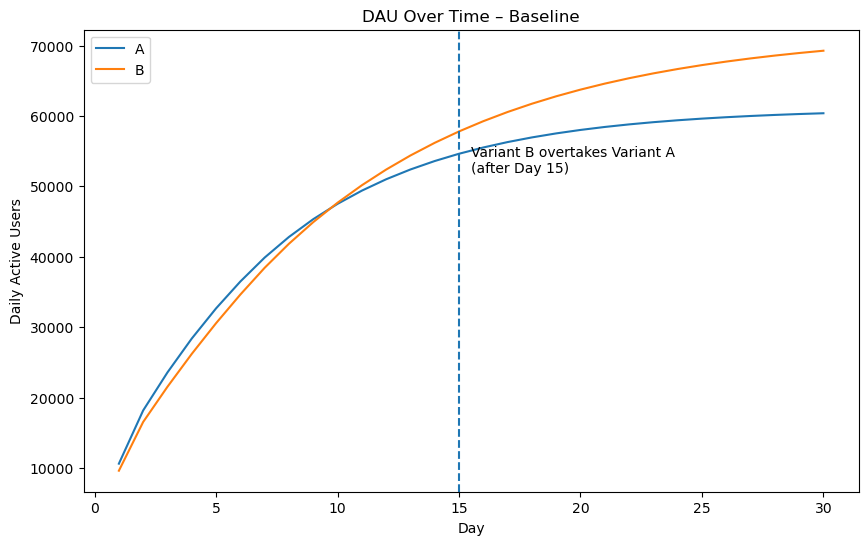

,A,B
1,10600.000000,9600.000000
2,18165.712128,16528.203230
3,23565.712128,21528.203230
4,28375.933340,26196.660654
5,32660.790397,30555.559598
6,36477.662676,34625.426424
7,39877.662676,38425.426424
8,42807.644755,41840.695056
9,45332.584456,44910.184484
10,47508.475066,47668.903157


In [3]:
df_dau.plot(figsize=(10, 6))

plt.axvline(15, linestyle="--")
plt.text(
    15.5,
    df_dau.max().max() * 0.75,
    "Variant B overtakes Variant A\n(after Day 15)",
)

plt.title("DAU Over Time – Baseline")
plt.xlabel("Day")
plt.ylabel("Daily Active Users")

plt.savefig(f"{OUTPUT_DIR}/dau_curves.png", bbox_inches="tight")
plt.show()

df_dau


In [4]:
daily_revenue = {}
cumulative_revenue = {}

for v, cfg in VARIANTS.items():
    daily = calculate_revenue(
        df_dau[v],
        cfg["purchase_rate"],
        ARPPU,
        cfg["ads_per_dau"],
        cfg["ecpm"]
    )
    daily_revenue[v] = daily
    cumulative_revenue[v] = daily.cumsum()

df_cumrev = pd.DataFrame(cumulative_revenue)


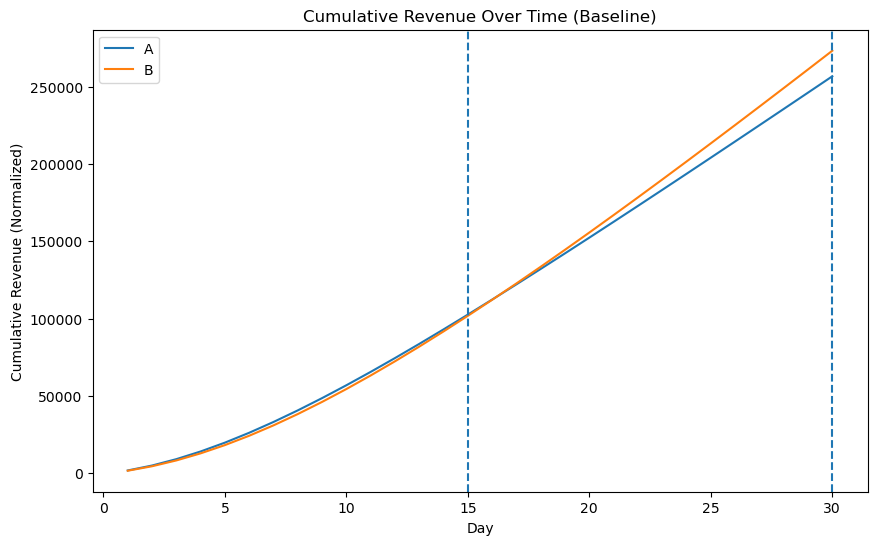

,A,B
1,1855.424000,1677.888000
2,5035.150251,4566.687361
3,9160.092502,8329.386721
4,14127.015873,12908.039070
5,19843.960625,18248.539777
6,26229.010699,24300.371807
7,33209.196774,31016.367838
8,40702.246912,38329.284519
9,48637.262495,46178.686563
10,56953.145971,54510.257457


In [5]:
df_cumrev.plot(figsize=(10, 6))

plt.axvline(15, linestyle="--")
plt.axvline(30, linestyle="--")

plt.title("Cumulative Revenue Over Time (Baseline)")
plt.xlabel("Day")
plt.ylabel("Cumulative Revenue (Normalized)")

plt.savefig(f"{OUTPUT_DIR}/cumulative_revenue.png", bbox_inches="tight")
plt.show()

df_cumrev


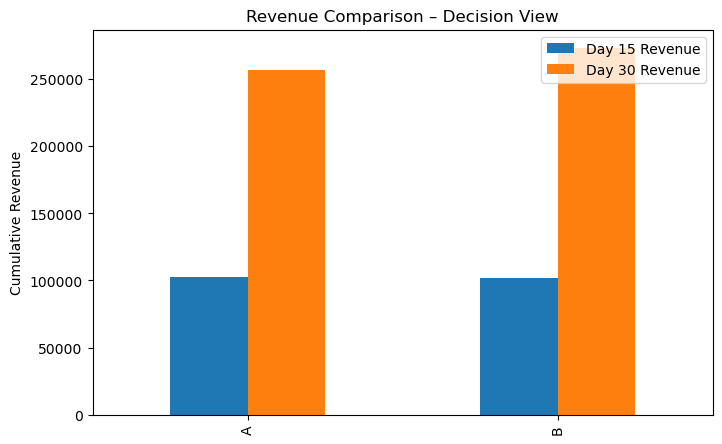

,Day 15 Revenue,Day 30 Revenue
A,102637.356947,256710.265104
B,101854.870264,273243.741612


In [6]:
summary = pd.DataFrame({
    "Day 15 Revenue": {
        v: df_cumrev[v].loc[15] for v in VARIANTS
    },
    "Day 30 Revenue": {
        v: df_cumrev[v].loc[30] for v in VARIANTS
    }
})

summary.plot(kind="bar", figsize=(8, 5))
plt.title("Revenue Comparison – Decision View")
plt.ylabel("Cumulative Revenue")

plt.savefig(f"{OUTPUT_DIR}/final_decision.png", bbox_inches="tight")
plt.show()

summary


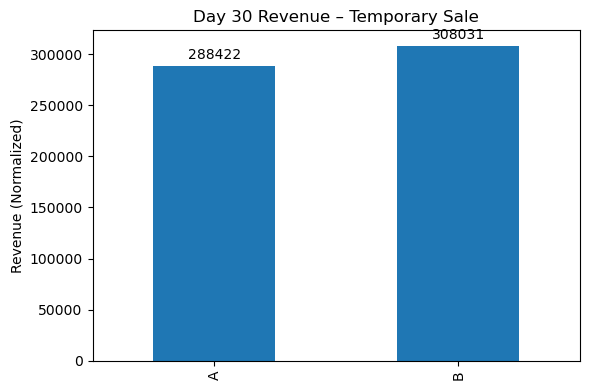

In [7]:
sale_up_revenue = {}

for v, cfg in VARIANTS.items():
    total = 0
    for day in range(1, DAYS + 1):
        pr = apply_sale_up(
            cfg["purchase_rate"],
            day,
            SALE_START,
            SALE_END,
            SALE_UPLIFT
        )
        total += calculate_revenue(
            df_dau.loc[day, v],
            pr,
            ARPPU,
            cfg["ads_per_dau"],
            cfg["ecpm"]
        )
    sale_up_revenue[v] = total

sale_up_df = pd.DataFrame(sale_up_revenue, index=["Day 30 – Sale"]).T

ax = sale_up_df.plot(
    kind="bar",
    figsize=(6, 4),
    legend=False,
    title="Day 30 Revenue – Temporary Sale"
)

plt.ylabel("Revenue (Normalized)")

add_bar_labels(ax, decimals=0)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/revenue_sale_uplift_day30.png", bbox_inches="tight")
plt.show()


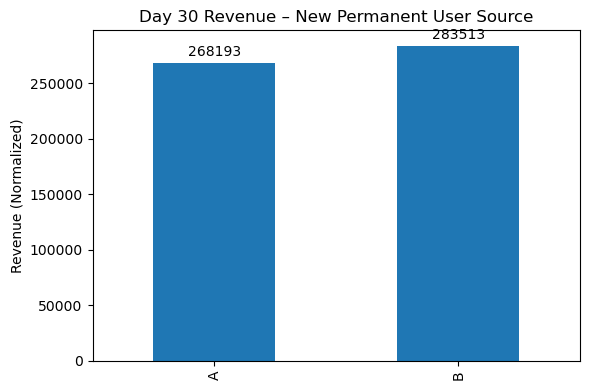

In [8]:
mixed_ua_revenue = {}

for v, cfg in VARIANTS.items():
    old_ret = build_log_linear_retention(cfg["retention_points"])
    new_ret = get_new_source_retention(v)

    dau = []
    for day in range(1, DAYS + 1):
        active = 0
        for install_day in range(1, day + 1):
            age = day - install_day + 1
            if install_day >= NEW_SOURCE_START:
                active += OLD_SOURCE_INSTALLS * old_ret(age)
                active += NEW_SOURCE_INSTALLS * new_ret(age)
            else:
                active += DAILY_INSTALLS * old_ret(age)
        dau.append(active)

    rev = calculate_revenue(
        pd.Series(dau),
        cfg["purchase_rate"],
        ARPPU,
        cfg["ads_per_dau"],
        cfg["ecpm"]
    )

    mixed_ua_revenue[v] = rev[:30].sum()

mixed_ua_df = pd.DataFrame(mixed_ua_revenue, index=["Day 30 – New Source"]).T

ax = mixed_ua_df.plot(
    kind="bar",
    figsize=(6, 4),
    legend=False,
    title="Day 30 Revenue – New Permanent User Source"
)

plt.ylabel("Revenue (Normalized)")

add_bar_labels(ax, decimals=0)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/revenue_new_source_day30.png", bbox_inches="tight")
plt.show()
